<a href="https://colab.research.google.com/github/lucasmoncada08/Chest-X-ray-Images-Pneumonia-Classifier/blob/master/Pneumonia_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 47.0MB/s 
  Found existing installation: torch 1.5.1+cu101
    Uninstalling torch-1.5.1+cu101:
      Successfully uninstalled torch-1.5.1+cu101
  Found existing installation: torchvision 0.6.1+cu101
    Uninstalling torchvision-0.6.1+cu101:
      Successfully uninstalled torchvision-0.6.1+cu101


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


#Preprocessing the Data

In [3]:
import zipfile
import os

zip_file = '/content/drive/My Drive/17810_23812_bundle_archive.zip'
zip_ref = zipfile.ZipFile(zip_file, 'r')
os.mkdir('/Pneumonia-Classifier')
zip_ref.extractall('/Pneumonia-Classifier')
zip_ref.close()

In [16]:
from fastai.vision import *
from fastai.metrics import error_rate

In [5]:
path = '/Pneumonia-Classifier/chest_xray/chest_xray'

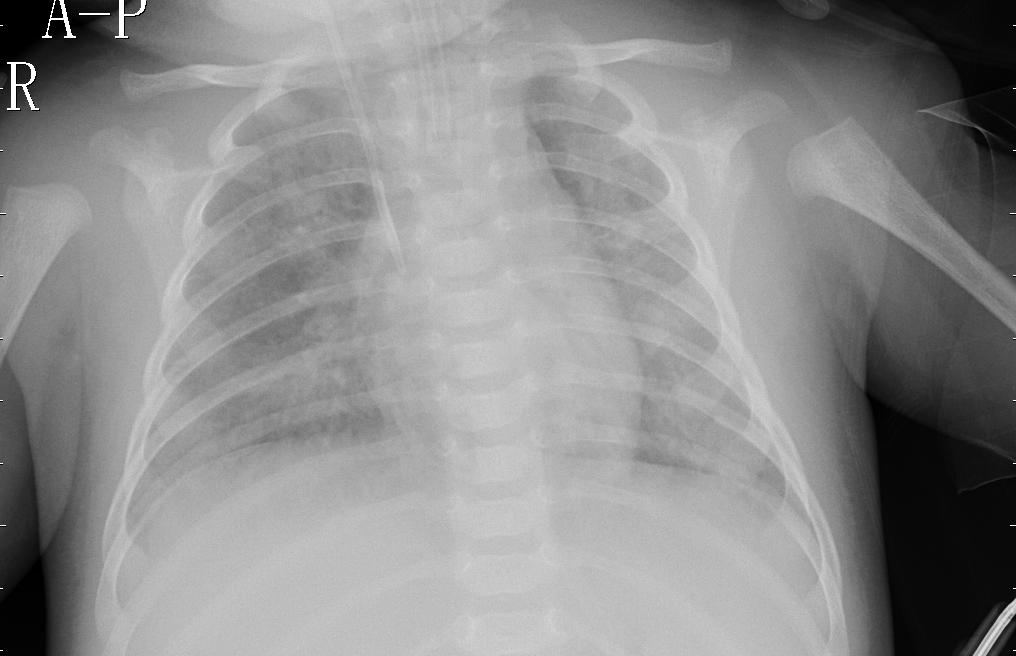

(656, 1016, 3)


In [13]:
import cv2
from google.colab.patches import cv2_imshow

im = cv2.imread('/Pneumonia-Classifier/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg')

cv2_imshow(im)
print(im.shape)

In [50]:
data = ImageDataBunch.from_folder(path, valid='val', test='test',
                                  ds_tfms=get_transforms(),
                                  size=400, bs=16)

In [51]:
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (5216 items)
x: ImageList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: CategoryList
NORMAL,NORMAL,NORMAL,NORMAL,NORMAL
Path: /Pneumonia-Classifier/chest_xray/chest_xray;

Valid: LabelList (16 items)
x: ImageList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: CategoryList
NORMAL,NORMAL,NORMAL,NORMAL,NORMAL
Path: /Pneumonia-Classifier/chest_xray/chest_xray;

Test: LabelList (624 items)
x: ImageList
Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400),Image (3, 400, 400)
y: EmptyLabelList
,,,,
Path: /Pneumonia-Classifier/chest_xray/chest_xray

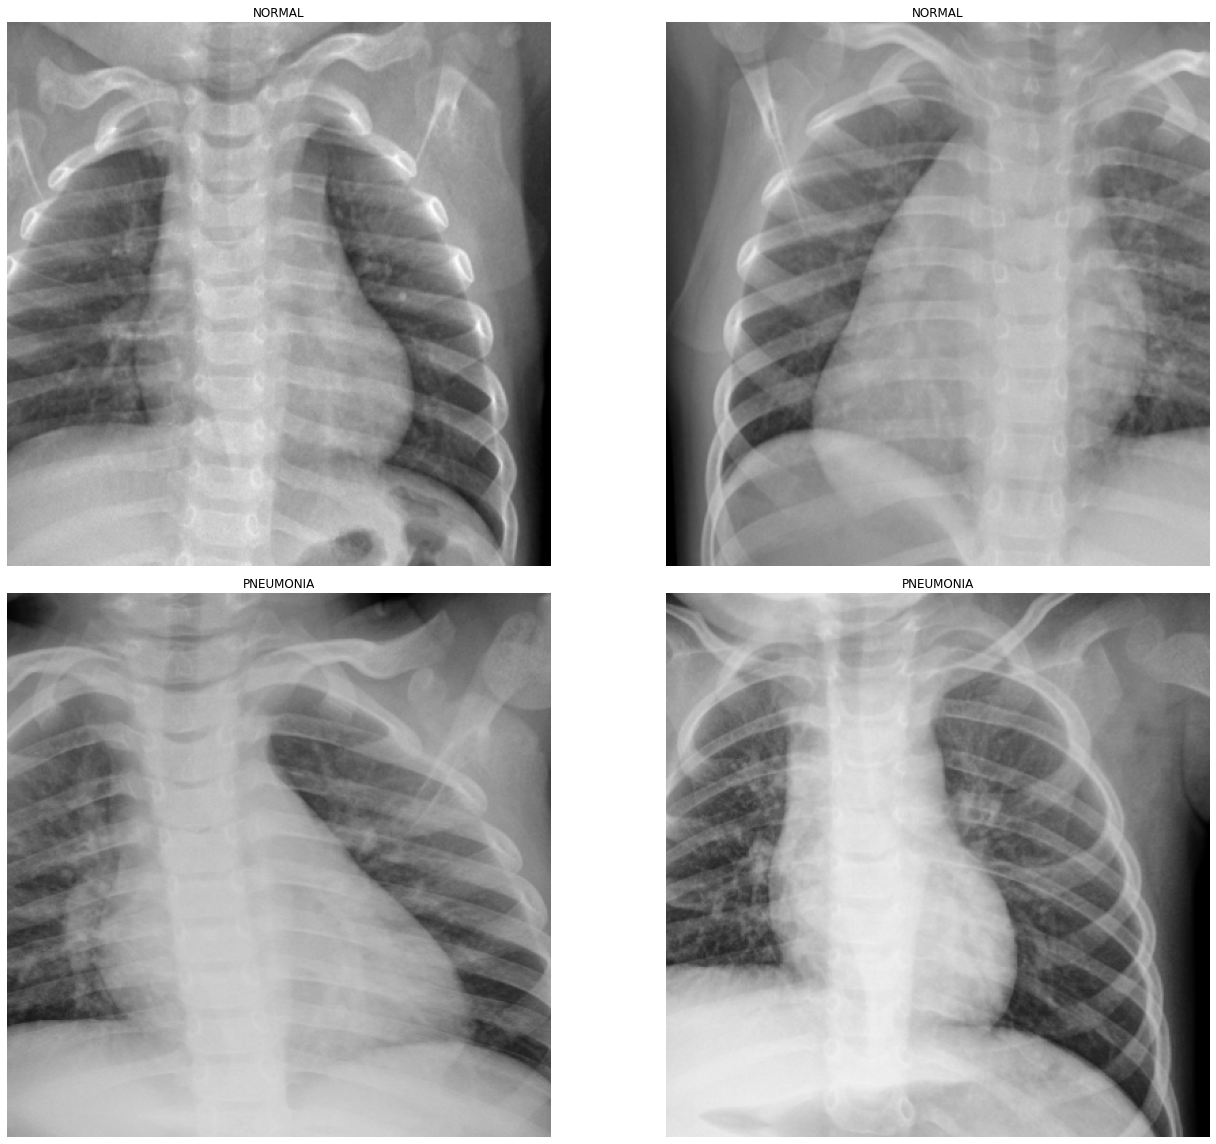

In [52]:
data.show_batch(rows=2, figsize=(20, 16))

In [42]:
print(data.classes)
print(len(data.classes), data.c)

['NORMAL', 'PNEUMONIA']
2 2


In [53]:
pd.value_counts(data.train_ds.y)

PNEUMONIA    3875
NORMAL       1341
dtype: int64

#Using Transfer Learning to Develop a Model

In [ ]:
# Use a pretrained learner (resnet)
learner = cnn_learner(data, models.resnet50, metrics=accuracy)

In [37]:
learner.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [55]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


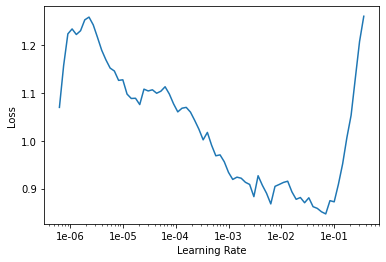

In [57]:
learner.recorder.plot()

In [58]:
learner.fit_one_cycle(5, max_lr=slice(1e-3, 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.286681,1.109149,0.625000,05:25
1,0.247550,0.647553,0.750000,05:20
2,0.154815,0.292834,0.937500,05:15
3,0.075039,0.060150,1.000000,05:12
4,0.062432,0.071692,1.000000,05:09


In [60]:
learner.save('stage-1', return_path=True)

PosixPath('/Pneumonia-Classifier/chest_xray/chest_xray/models/stage-1.pth')

## Evaluating the Model

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)

interp.plot_top_losses(4, figsize=(16, 12))

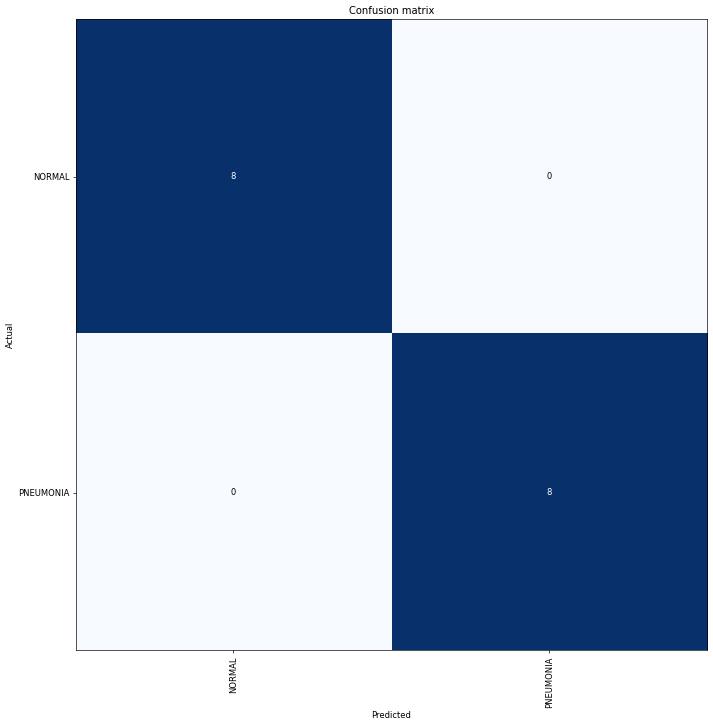

In [62]:
interp.plot_confusion_matrix(figsize=(12, 12), dpi=60)

In [89]:
test_normal_path = '/Pneumonia-Classifier/chest_xray/test/NORMAL'
data_test_normal = ImageList.from_folder(test_normal_path)
print(len(data_test_normal))

234


In [92]:
test_pneumonia_path = '/Pneumonia-Classifier/chest_xray/test/PNEUMONIA'
data_test_pneumonia = ImageList.from_folder(test_pneumonia_path)
print(len(data_test_pneumonia))

390


In [124]:
test_labels = np.empty((624), dtype=object)
for i in range(234):
  test_labels[i] = 'NORMAL'
for i in range(234, 624):
  test_labels[i] = 'PNEUMONIA'

In [127]:
print(test_labels[0])
print(test_labels[623])
print(type(test_labels[0]))

NORMAL
PNEUMONIA
<class 'str'>


In [129]:
print(str(learner.predict(data.test_ds[0][0])[0]))
print(str(learner.predict(data.test_ds[623][0])[0]))

NORMAL
PNEUMONIA


In [131]:
test_preds = np.zeros((624), dtype=object)
for i in range(624):
  test_preds[i] = str(learner.predict(data.test_ds[i][0])[0])

In [132]:
print(test_preds[0])
print(test_preds[623])
print(type(test_preds[0]))

NORMAL
PNEUMONIA
<class 'str'>


In [136]:
from sklearn.metrics import confusion_matrix, recall_score

In [142]:
cm = confusion_matrix(test_labels, test_preds)
print(cm)

[[181  53]
 [  3 387]]
181


In [143]:
recall = cm[0][0]/(cm[0][0]+cm[1][0])
prec = cm[0][0]/(cm[0][0]+cm[0][1])
acc = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
print('Recall:', recall)
print('Precision:', prec)
print('Accuracy:', acc)

Recall: 0.9836956521739131
Precision: 0.7735042735042735
Accuracy: 0.9102564102564102


# Fine Tuning the Model More

In [144]:
learner.unfreeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


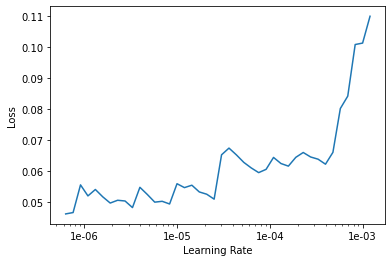

In [145]:
# Find the optimal learning rate
learner.lr_find()
learner.recorder.plot()

In [146]:
# Training the entire model for 5 epochs
learner.fit_one_cycle(5, max_lr=slice(1e-6, 1e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.064295,0.069239,1.000000,05:23
1,0.049865,0.070496,1.000000,05:28
2,0.044139,0.041251,1.000000,05:29
3,0.058635,0.062994,1.000000,05:28
4,0.051629,0.049736,1.000000,05:28


## Evaluating the Model Again

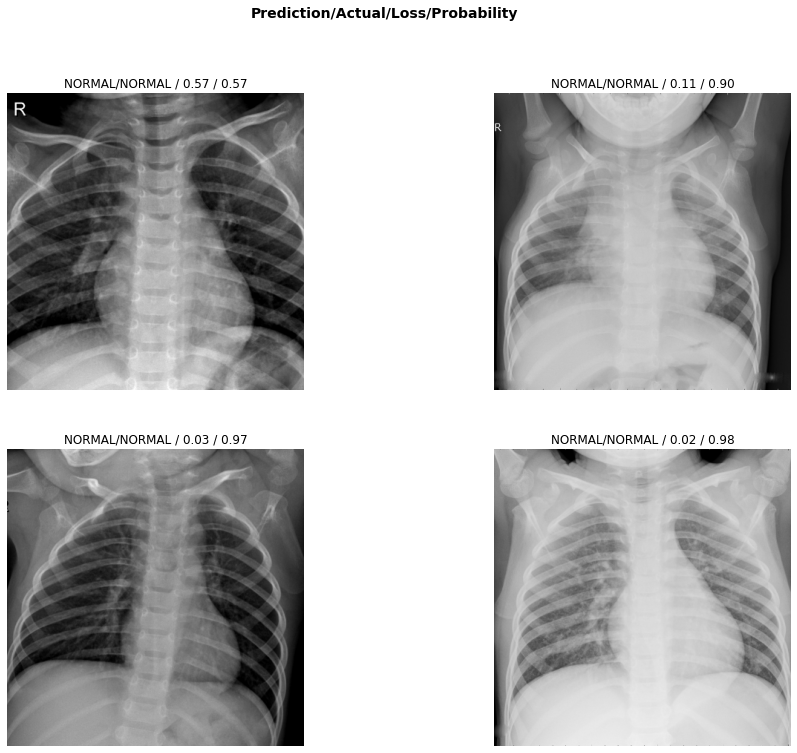

In [147]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_top_losses(4, figsize=(16, 12))

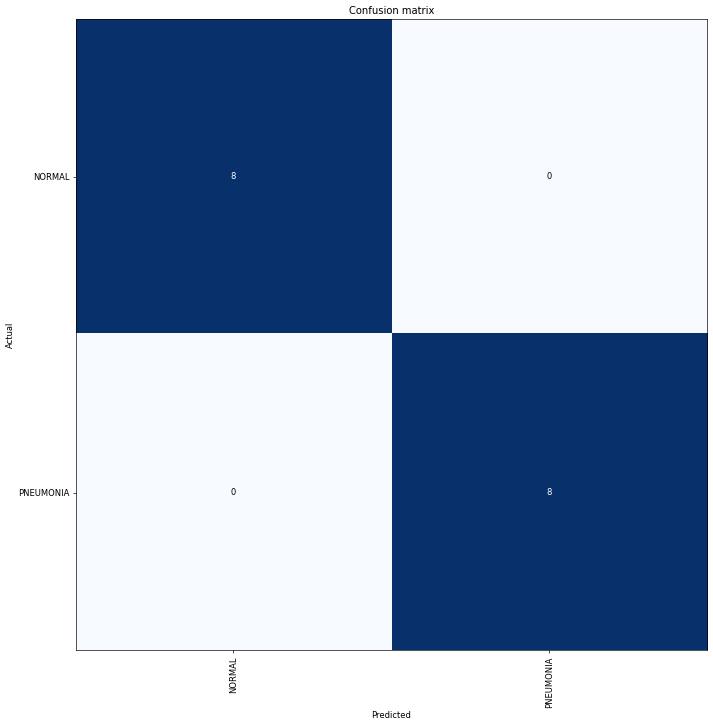

In [148]:
interp.plot_confusion_matrix(figsize=(12, 12), dpi=60)

In [149]:
# Creating a test predictions vector
test_preds = np.zeros((624), dtype=object)
for i in range(624):
  test_preds[i] = str(learner.predict(data.test_ds[i][0])[0])

In [151]:
cm = confusion_matrix(test_labels, test_preds)
print(cm)

[[180  54]
 [  3 387]]


In [152]:
recall = cm[0][0]/(cm[0][0]+cm[1][0])
prec = cm[0][0]/(cm[0][0]+cm[0][1])
acc = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
print('Recall:', recall)
print('Precision:', prec)
print('Accuracy:', acc)

Recall: 0.9836065573770492
Precision: 0.7692307692307693
Accuracy: 0.9086538461538461


In [153]:
learner.save('stage-2')